In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 23.7 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

# Sz=0, the three lowest state using exact diagonalization for HLi

After creating the LiH's Hamitonian in terms of Pauli operators. We directly diagonalize the Hamiltonian and filter out the states which don't conserve the charge.

In [ ]:
def vec_check(vec,electron_num):
    """
    To check whether solution conserves the charge
    Arg:
       vec: the state vector (numpy array).
       electron_num: the number of electrons
    """
    for i,e in enumerate(vec):
        if np.abs(e) > 1e-8:
            e_occ=bin(i)[2:]
            lst=' '.join(e_occ).split(' ')
            cv=tuple(map(int, lst))
            e_num=sum(cv)
            if e_num!=electron_num:
                return False
    return True

def exact_ch_energy_sz_0(num_electrons,symbol,geometry,charge):
    """
      num_electrons: The number of electrons

      symbol: The chemistry symbol (i.e. ["H","H"] for H2)

      geometry: The coodinates of the atoms in bohr

      charge: the charge of the chemical molecules

      return: the three lowest states with Sz=0
    """

    Ha=qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]
    H_matrix=qml.matrix(Ha)
    sz=qml.qchem.spinz(len(Ha.wires))
    SZ=qml.matrix(sz)
    vals, vecs = np.linalg.eigh(H_matrix+0.00001*SZ)

    inds=np.argsort(vals)
    eng=vals[inds]
    vec=vecs[:,inds]
    E_collect=[eng[0]]
    print('The ground state energy with sz=0:',eng[0])

    elec_num=num_electrons
    k=0
    for i in range(1,len(eng)): # Finding first excited state with -1 Sz
        Sz=vec[:,i].dot(SZ.dot(np.transpose(np.conjugate(vec[:,i]))))
        if  np.abs(Sz.real)<1e-5 and vec_check(vec[:,i],elec_num):
            print('The energy state:',(eng[i]-0.00001*Sz).real,' with Sz=',round(Sz.real,3))

            E_collect.append((eng[i]-0.00001*Sz).real)
            k+=1
        if k==2:
            break

    return E_collect


In [ ]:
r_lst=[0.4,0.8,1.2,1.6,2.0,2.4,2.8,3.2,3.6,4.0] # Radius list
E_dict={}

E_0__lst=[]
E_1__lst=[]
E_2__lst=[]

for r in r_lst:
    a0=0.529177210903
    L=r/a0                    # Convert unit from Bohr to atomic unit
    symbol=["H", "Li"]        # HLi
    geometry=np.array([0.0, 0.0, -L/2, 0.0, 0.0, L/2])

    charge=0
    num_electrons=2
    E0,E1,E2=exact_ch_energy_sz_0(num_electrons,symbol,geometry,charge)

    E_0__lst.append(E0)
    E_1__lst.append(E1)
    E_2__lst.append(E2)



The ground state energy with sz=0: -6.636422053391626
The energy state: -6.602847378339246  with Sz= -0.0
The energy state: -6.571910976028578  with Sz= -0.0
The ground state energy with sz=0: -7.633380433159381
The energy state: -7.528728412965157  with Sz= 0.0
The energy state: -7.5135275363729965  with Sz= -0.0
The ground state energy with sz=0: -7.8521612665049565
The energy state: -7.720610027255654  with Sz= 0.0
The energy state: -7.705938101807431  with Sz= 0.0
The ground state energy with sz=0: -7.882096614586634
The energy state: -7.766004935721784  with Sz= -0.0
The energy state: -7.748714871575249  with Sz= 0.0
The ground state energy with sz=0: -7.860828281841016
The energy state: -7.775551605885377  with Sz= 0.0
The energy state: -7.752282360954608  with Sz= -0.0
The ground state energy with sz=0: -7.830342982229369
The energy state: -7.777297865531235  with Sz= -0.0
The energy state: -7.743935505243651  with Sz= -0.0
The ground state energy with sz=0: -7.806439842532212
T

# Variational Quantum Deflation

VQD is the VQE to evaluate the k th excited state's energy with the cost function

$C\left(\vec{\theta}_{k}\right)=\left\langle \psi_{k}(\vec{\theta}_{k})\left|H\right|\psi_{k}(\vec{\theta}_{k})\right\rangle +\sum_{i=0}^{k-1}\beta_i\left|\left\langle \psi_{i}(\vec{\theta}_{i})|\psi_{k}(\vec{\theta}_{k})\right\rangle ^{2}\right|$

Where and $\left|\psi_{i}(\vec{\theta_{i}})\right\rangle$ are the k-1 lowest eigenstates which put the cconstraints that $\left|\psi_{k}(\vec{\theta_{k}})\right\rangle $ is orthognal to thoes eigenstates. $\left|\psi_{k}\right\rangle $, $\left|\psi_{k-1}\right\rangle $.... means different initial trial states.Moreover, $\beta_i$ is should sfficient (larger than the band gap between the ground state and the first excited state.)





As the plot shown below, each qubit can be explained whether the electrons occupy the spin orbitals. $1$ means the occupied orbital, while $0$ means empty orbital. Even (odd) sites mean spin up (down) orbital. (Plot from	Phys. Chem. Chem. Phys., 2021,23, 26438-26450)

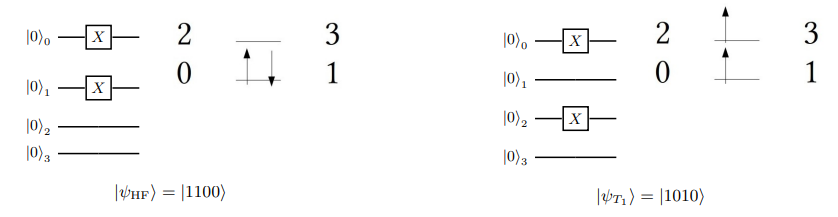

In [ ]:
def bit_to_vec(bitstring_dict,num_qubits): # Convert the bitstring to statevector

    vec=np.zeros(2**num_qubits)
    amp=0
    for i in range(2**num_qubits):
        bitstr=bin(i)[2:]
        if len(bitstr) < num_qubits:
            bitstr=(num_qubits-len(bitstr))*'0'+bitstr

        if bitstr in bitstring_dict:
            vec[i]=bitstring_dict[bitstr]
            amp+=np.abs(bitstring_dict[bitstr])**2
    vec=vec/np.sqrt(amp)
    return vec

In [ ]:
class VQD_ch():
    def __init__(self,state_lst,num_electrons,symbol,geometry,charge):
        """
        state_lst list(dict): The list of trial states for training the VQD

        For instance, you want to create |ψ_1>=1/√2|110000>+1/√2|001100>
        and |ψ_2>=1/√2|110000>-1/√2|001100> as the 6 qubits trial states

        state_psi_1={'110000':1,'001100':1}
        state_psi_2={'110000':1,'001100':-1}
        state_lst=[state_psi_1,state_psi_2]

        The length of bitstring is determined by the number of orbital. H3+ has 6 orbitals so the
        of bit string is 6.

        num_electrons (int): The number of electrons

        symbol list(str): The chemistry symbol (i.e. ["H","H"] for H2)

        geometry numpy array: The coodinates of the atoms in bohr

        charge int: the charge of the chemical molecules
        """

        self.num_electrons=num_electrons
        self.symbol=symbol
        self.geometry=geometry
        self.charge=charge

        self.hamiltonian=self.Ch_hamiltonian(symbol,geometry,num_electrons,charge)
        self.num_qubits = len(self.hamiltonian.wires)
        generators = qml.symmetry_generators(self.hamiltonian)
        paulixops = qml.paulix_ops(generators, self.num_qubits)

        paulix_sector=qml.qchem.optimal_sector(self.hamiltonian, generators, self.num_electrons)
        H_tapered = qml.taper(self.hamiltonian, generators, paulixops, paulix_sector)
        self.H_tapered = qml.Hamiltonian(np.real(H_tapered.coeffs), H_tapered.ops)

        self.sz=qml.qchem.spinz(self.num_qubits)

        print(self.H_tapered.wires)

        Sz_tapered = qml.taper(self.sz, generators, paulixops, paulix_sector)
        self.Sz_tapered = qml.Hamiltonian(np.real(Sz_tapered.coeffs), Sz_tapered.ops)

        self.singles, self.doubles = qml.qchem.excitations(self.num_electrons, self.num_qubits)

        tapered_doubles = [\
            qml.taper_operation(qml.DoubleExcitation, generators, paulixops, paulix_sector,\
                        wire_order=self.hamiltonian.wires, op_wires=double) for double in self.doubles]

        self.tapered_doubles=[]
        for op_taper in tapered_doubles:
            if op_taper(np.pi/5):
                self.tapered_doubles.append(op_taper)

        tapered_singles = [\
            qml.taper_operation(qml.SingleExcitation, generators, paulixops, paulix_sector,\
                                wire_order=self.hamiltonian.wires, op_wires=single) for single in self.singles]

        self.tapered_singles=[]
        for op_taper in tapered_singles:
            if op_taper(np.pi/5):
                self.tapered_singles.append(op_taper)

        self.num_qubits=len(self.H_tapered.wires)
        self.state_lst=[]
        for stat in state_lst:
            self.state_lst.append(bit_to_vec(stat,self.num_qubits))

        self.op_lst=self.tapered_singles+self.tapered_doubles

        self.weight_dict={}
        self.th_state=0
        self.Eng_lst=[]

        self.dev = qml.device("default.qubit", wires=self.H_tapered.wires)
        self.cost_h_fn = qml.QNode(self.circuit, self.dev)
        self.Sz_fn = qml.QNode(self.circuit_sz, self.dev)
        self.cost_fid_fn = qml.QNode(self.circuit_fid, self.dev)
        self.num_ly_lst=[]
        self.num_op=len(self.tapered_singles+self.tapered_doubles)
        self.fix_op_dict={}

    def Ch_hamiltonian(self,symbol,geometry,num_electrons,charge): # Create the Hamiltonian of molecules
        return qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]

    def hf(self,electrons, num_qubits): #Create trial state for the ground state
        return qml.qchem.hf_state(electrons=electrons, orbitals=num_qubits)

    def circuit(self,state,weights): #evalutate the expectation value of the Hamiltonian
        qml.StatePrep(state, wires=self.H_tapered.wires)
        op_lst=self.op_lst.copy()*self.num_layer
        for idx, tapered_op in enumerate(op_lst):
            tapered_op(weights[idx])
        return qml.expval(self.H_tapered)

    def circuit_sz(self,state,weights): #evalutate the expectation value of the Sz
        qml.StatePrep(state, wires=self.H_tapered.wires)
        op_lst=self.op_lst.copy()*self.num_layer
        for idx, tapered_op in enumerate(op_lst):
            tapered_op(weights[idx])

        return qml.expval(self.Sz_tapered)

    def circuit_fid(self,state,params,ind): #To calculate the fidelity between one of trained states and training state.
        qml.StatePrep(state, wires=self.H_tapered.wires)
        #Re_w=self.weight_dict[ind].copy()
        op_lst=self.op_lst.copy()*self.num_layer
        #rev_op_lst=self.op_lst.copy()[::-1]*self.num_ly_lst[ind]
        for idx, tapered_op in enumerate(op_lst):
            #print(tapered_op(params[idx]))
            tapered_op(params[idx])

        for idx, op in enumerate(self.fix_op_dict[ind][::-1]):
            qml.adjoint(op)

        return qml.state()

    def op_fn(self,params,ind):
        op_lst=self.op_lst.copy()*self.num_ly_lst[ind]
        for idx, tapered_op in enumerate(op_lst):
            tapered_op(params[idx])


    def cost_fn(self,params):

        cost=self.cost_h_fn(self.stat,params)
        for ind in range(self.th_state):
            coj_stat=np.conjugate(np.transpose(self.state_lst[ind]))
            final_stat=self.cost_fid_fn(self.stat,params,ind)
            fid=np.abs(np.dot(coj_stat,final_stat))**2
            cost+=self.beta*fid
        return cost

    def run(self,beta=3.0,epochs=400,stepsize=0.5,num_layer=2,cov=1e-5,print_train=True):
        """
        beta: the coefficient (larger than the bandgap)

        epochs: the iteration of training

        stepsize: the learning rate

        num_layer: the number of layer ansatz

        cov: if the difference between previous cost and current is samller than cov, the training will be stopped

        print_train: Whether you want to print the training process
        """

        if self.th_state==len(self.state_lst):
            print('Run of states')
            return None
        self.beta=beta
        self.stat=self.state_lst[self.th_state]
        self.num_layer=num_layer
        opt = qml.AdamOptimizer(stepsize=stepsize)
        self.weights =np.zeros(self.num_layer*len(self.tapered_doubles + self.tapered_singles), requires_grad=True)

        i=0
        iter=[]
        cost_val=[]
        Lowest_cost=0

        cov=cov
        E_pev=0

        for _ in range(epochs):
            self.weights = opt.step(self.cost_fn, self.weights)
            iter.append(i)
            cost=self.cost_fn(self.weights)

            E0=self.cost_h_fn(self.stat,self.weights)

            cost_val.append(E0)

            i=i+1
            if print_train:
                print('iter:',i)
                print(' E0:',E0,' Sz:',self.Sz_fn(self.stat,self.weights))
                print(cost)
            if np.abs(E0-E_pev)<cov:
                break

            E_pev=E0
        self.Eng_lst=E0
        self.weight_dict[self.th_state]=self.weights

        op_lst=self.op_lst*self.num_layer
        self.fix_op_dict[self.th_state]=[]
        for idx, op in enumerate(op_lst):
            self.fix_op_dict[self.th_state]=self.fix_op_dict[self.th_state]+op(self.weights[idx])
        self.iter_lst=iter
        self.th_state+=1
        self.num_ly_lst.append(self.num_layer)

        return self.cost_h_fn(self.stat,self.weights)

# For Sz=0, finding the three lowest energy using VQD

In [ ]:
r_lst=[0.4,0.8,1.2,1.6,2.0,2.4,2.8,3.2,3.6,4.0]
E_dict={}

E0_lst=[]
E1_lst=[]
E2_lst=[]

iter0_lst=[]
iter1_lst=[]
iter2_lst=[]

for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H", "Li"]
    geometry=np.array([0.0, 0.0, -L/2, 0.0, 0.0, L/2])

    charge=0
    num_electrons=2

    #We guess how ground state looks like
    g_stat={'110000': 1}

    ## We guess how the excited state with Sz=0 looks like
    if r==4.0:
        e_stat_0={'110000': 1}
        e_stat_1={'110000': 1}

    else:
        e_stat_0={'100100': 1,'011000': -1}
        e_stat_1={'011000': 1,'100100':1}


    stat_lst=[g_stat,e_stat_0,e_stat_1]
    VQD=VQD_ch(stat_lst,num_electrons,symbol,geometry,charge)
    print('Running '+str(r))

    E0=VQD.run(epochs=400,stepsize=0.3,num_layer=2)
    iter0_lst.append(VQD.iter_lst[-1])
    E1=VQD.run(epochs=400,stepsize=0.3,num_layer=3)
    iter1_lst.append(VQD.iter_lst[-1])
    E2=VQD.run(epochs=400,stepsize=0.3,num_layer=4)
    iter2_lst.append(VQD.iter_lst[-1])

    E0_lst.append(E0)
    E1_lst.append(E1)
    E2_lst.append(E2)


Streaming output truncated to the last 5000 lines.
iter: 50
 E0: -7.85131731373087  Sz: 2.7755575615628914e-17
-7.85131731373087
iter: 51
 E0: -7.8518596855161045  Sz: 0.0
-7.8518596855161045
iter: 52
 E0: -7.851837274430088  Sz: -5.551115123125783e-17
-7.851837274430088
iter: 53
 E0: -7.851510191172661  Sz: 8.326672684688674e-17
-7.851510191172661
iter: 54
 E0: -7.8514583815034475  Sz: 2.7755575615628914e-17
-7.8514583815034475
iter: 55
 E0: -7.851757164734305  Sz: 0.0
-7.851757164734305
iter: 56
 E0: -7.851981735732501  Sz: 2.7755575615628914e-17
-7.851981735732501
iter: 57
 E0: -7.851861188174266  Sz: 2.7755575615628914e-17
-7.851861188174266
iter: 58
 E0: -7.85169499100559  Sz: 0.0
-7.85169499100559
iter: 59
 E0: -7.851816990410796  Sz: -2.7755575615628914e-17
-7.851816990410796
iter: 60
 E0: -7.852028248864035  Sz: 0.0
-7.852028248864035
iter: 61
 E0: -7.852011272646029  Sz: 0.0
-7.852011272646029
iter: 62
 E0: -7.851867678140976  Sz: 0.0
-7.851867678140976
iter: 63
 E0: -7.851875

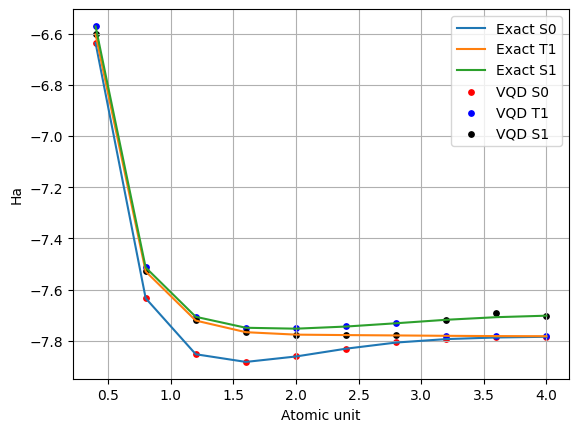

In [ ]:
plt.plot(r_lst,E_0__lst,label='Exact S0')
plt.plot(r_lst,E_1__lst,label='Exact T1')
plt.plot(r_lst,E_2__lst,label='Exact S1')

plt.scatter(r_lst,E0_lst,s=15,c='r',label='VQD S0')
plt.scatter(r_lst,E1_lst,s=15,c='b',label='VQD T1')
plt.scatter(r_lst,E2_lst,s=15,c='k',label='VQD S1')

plt.xlabel('Atomic unit')
plt.ylabel('Ha')

plt.grid()
plt.legend()

In [ ]:
with open('T_VQD_S0.npy', 'wb') as f:
    np.save(f, np.array(E0_lst))

with open('T_VQD_T1.npy', 'wb') as f:
    np.save(f, np.array(E1_lst))

with open('T_VQD_S1.npy', 'wb') as f:
    np.save(f, np.array(E2_lst))

In [ ]:
with open('T_VQD_iter1.npy', 'wb') as f:
    np.save(f, np.array(iter0_lst))

with open('T_VQD_iter2.npy', 'wb') as f:
    np.save(f, np.array(iter1_lst))

with open('T_VQD_iter3.npy', 'wb') as f:
    np.save(f, np.array(iter2_lst))

In [ ]:
Rel0=np.abs(np.array(E_0__lst)-np.array(E0_lst))/np.abs(np.array(E_0__lst))
Rel1=np.abs(np.array(E_1__lst)-np.array(E1_lst))/np.abs(np.array(E_1__lst))
Rel2=np.abs(np.array(E_2__lst)-np.array(E2_lst))/np.abs(np.array(E_2__lst))

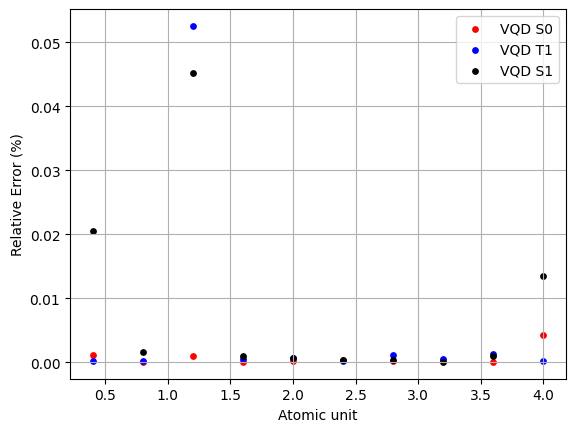

In [ ]:

plt.scatter(r_lst,Rel0*100,s=15,c='r',label='VQD S0')
plt.scatter(r_lst,Rel1*100,s=15,c='b',label='VQD T1')
plt.scatter(r_lst,Rel2*100,s=15,c='k',label='VQD S1')

plt.xlabel('Atomic unit')
plt.ylabel('Relative Error (%)')

plt.grid()
plt.legend()